In [90]:
import pandas as pd

In [91]:
df=pd.read_csv('stock_price.csv')
#check if we are fetching the right data
df

,Date,Close,Open,High,Low,Volume,Change
0,01-08-2024,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,31-07-2024,160.4,158.2,160.7,158.1,173.91M,1.07%
2,30-07-2024,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,29-07-2024,159.7,158.7,160.2,158.4,126.28M,1.14%
4,26-07-2024,157.9,159.3,159.6,157.9,155.08M,-0.13%
...,...,...,...,...,...,...,...
9197,18-02-1987,191.2,186.3,191.2,186.3,795.09M,4.82%
9198,17-02-1987,182.4,176.5,184.3,175.5,881.51M,3.93%
9199,16-02-1987,175.5,166.7,175.5,165.7,360.51M,1.74%
9200,13-02-1987,172.5,176.5,176.5,172.5,422.38M,-5.43%


In [92]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set 'Date' as the index for easier time-based slicing
df.set_index('Date', inplace=True)
df.head()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [93]:
def clean_percentage(change):
    if isinstance(change, str):  # Check if the value is a string
        return float(change.replace('%', ''))
    return change  # Return the original value if it's already numeric or NaN

df['Change'] = df['Change'].apply(clean_percentage)

def convert_volume(volume):
    if isinstance(volume, str):
        volume = volume.strip()
        if 'B' in volume:
            return float(volume.replace('B', '')) * 1e9  # Convert billions
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1e6  # Convert millions
    elif isinstance(volume, (float, int)):
        return volume
    return np.nan

# Apply the function to the Volume column
df['Volume'] = df['Volume'].apply(convert_volume)
df = df.iloc[::-1]
df.isnull().sum()


,0
Close,0
Open,0
High,0
Low,0
Volume,0
Change,0


In [94]:
df.head()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,3.93
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,4.82


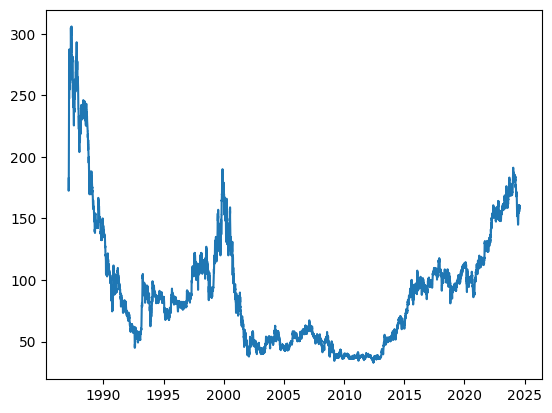

In [95]:
#plot for reference
import matplotlib.pyplot as plt
plt.plot(df['Close'])


In [96]:
#new variable with values from df['Close']
df1=df.reset_index()['Close']


In [97]:
#Scale the closing price to [0,1] with min max scalar
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [98]:
#split dataset for training and testing 65:35
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [99]:
#check their sizes
training_size,test_size

(5981, 3221)

In [100]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [101]:
time_step = 100
#create data sets with timesteps for training and testing
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [102]:
print(X_test)


[[0.01795529 0.01978747 0.0190546  ... 0.0190546  0.02052034 0.02565042]
 [0.01978747 0.0190546  0.02198608 ... 0.02052034 0.02565042 0.02674973]
 [0.0190546  0.02198608 0.01978747 ... 0.02565042 0.02674973 0.02601686]
 ...
 [0.54122389 0.54122389 0.54635398 ... 0.45987541 0.45840967 0.4576768 ]
 [0.54122389 0.54635398 0.55368267 ... 0.45840967 0.4576768  0.46427263]
 [0.54635398 0.55368267 0.55881275 ... 0.4576768  0.46427263 0.46060828]]


In [103]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [104]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [105]:
#our model
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()

model.add(Flatten(input_shape=(100, 1)))

# Add Dense layers instead of LSTMs
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1))  # Regression output for stock price prediction

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
#test our model using test data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 1.4364e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4103e-04 - val_loss: 9.6266e-05
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3945e-04 - val_loss: 1.0873e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5358e-04 - val_loss: 1.5090e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0018e-04 - val_loss: 6.8021e-05
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9086e-04 - val_loss: 1.6782e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7798e-04 - val_loss: 1.7750e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8060e-04 - val_loss: 5.9012e-05
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4420e-04 - val_loss: 1.3694e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8306e-04 - val_loss: 7.1485e-05


In [108]:
import tensorflow as tf


In [109]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Assuming you already have y_test (true values) and y_pred (predicted values)
# Calculate MAE
mae = mean_absolute_error(y_train, train_predict)

# Calculate MSE
mse = mean_squared_error(y_train, train_predict)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_train, train_predict)

# Step 2: Create a table of the results using pandas
error_metrics = {
    'Error Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
}

error_table = pd.DataFrame(error_metrics)
print(error_table)


  Error Metric       Value
0          MAE    0.007044
1          MSE    0.000120
2         RMSE    0.010971
3         MAPE  222.582240


In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Assuming you already have y_test (true values) and y_pred (predicted values)
# Calculate MAE
mae = mean_absolute_error(ytest, test_predict)

# Calculate MSE
mse = mean_squared_error(ytest, test_predict)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(ytest, test_predict)

# Step 2: Create a table of the results using pandas
error_metrics = {
    'Error Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
}

error_table = pd.DataFrame(error_metrics)
print(error_table)


  Error Metric     Value
0          MAE  0.006245
1          MSE  0.000071
2         RMSE  0.008455
3         MAPE       inf


<ipython-input-111-a2587ea5cdba>:17: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [112]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

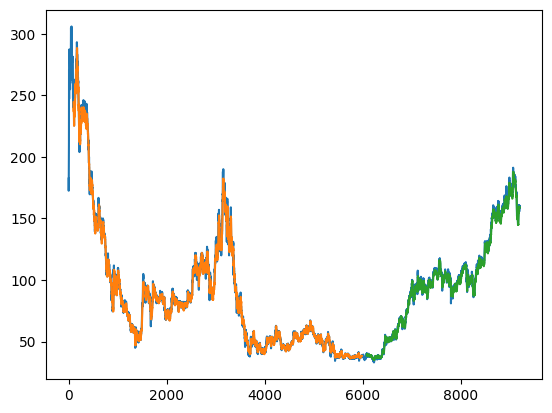

In [113]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [114]:
#to predict stocks for next 30 days
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 2880)

In [115]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [116]:
from numpy import array

lst_output = []
n_steps = 100
i = 0

while(i < 30):

    if(len(temp_input) > 100):
        # Slice the input to match n_steps (100 steps)
        x_input = np.array(temp_input[-100:])  # Take the last 100 elements
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)  # Reshape to (1, 100, 1)

        # Make a prediction
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Update temp_input with the predicted value
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep only the last 100 elements

        lst_output.extend(yhat.tolist())
        i += 1

    else:
        # Initial prediction if temp_input is smaller than 100
        x_input = np.array(temp_input).reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        # Update temp_input with the predicted value
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

0 day input [0.55881275 0.54745328 0.54195676 0.54085746 0.54525467 0.54049102
 0.54195676 0.54635398 0.53939172 0.55148406 0.54965189 0.5540491
 0.55331623 0.53865885 0.53792598 0.52656651 0.52913155 0.52876512
 0.52033712 0.52033712 0.52216929 0.52693294 0.52253573 0.52143642
 0.52106999 0.51887138 0.51080982 0.50164896 0.50128252 0.49432026
 0.50934408 0.50714547 0.50567974 0.49981678 0.49541957 0.50494687
 0.50384756 0.50348113 0.50128252 0.49505313 0.49432026 0.47379993
 0.4661048  0.46353976 0.45327959 0.44338586 0.43532429 0.43532429
 0.44045438 0.44521803 0.43898864 0.43825577 0.44998168 0.44265299
 0.43605716 0.43679003 0.44448516 0.4470502  0.44411872 0.43788934
 0.43349212 0.42872847 0.43312569 0.42946134 0.42139978 0.42066691
 0.41590326 0.41004031 0.41223892 0.41260535 0.41407109 0.41773543
 0.42652986 0.43202638 0.43349212 0.43349212 0.43532429 0.45144742
 0.45144742 0.45987541 0.4565775  0.45034811 0.44448516 0.45254672
 0.45914254 0.46353976 0.46060828 0.45511176 0.4642

In [117]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

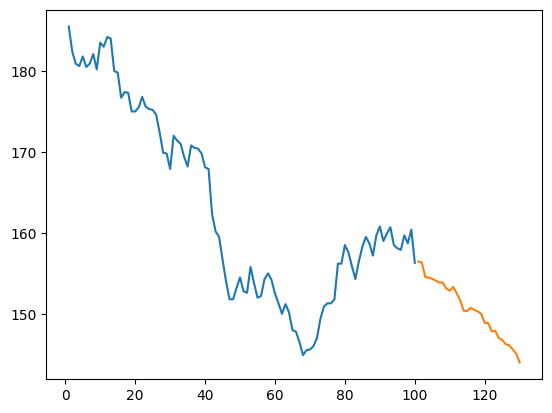

In [118]:
#plot the calculated curve
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[9102:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

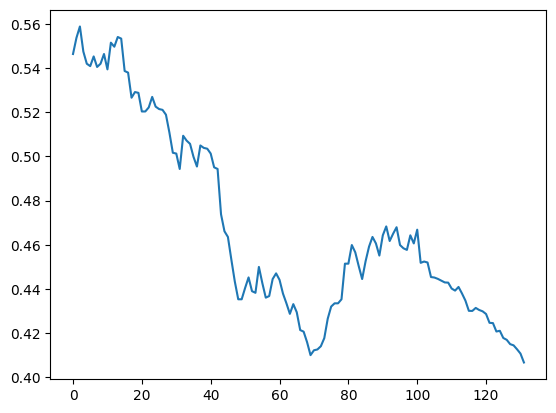

In [119]:
#remove discontinuity
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[9100:])

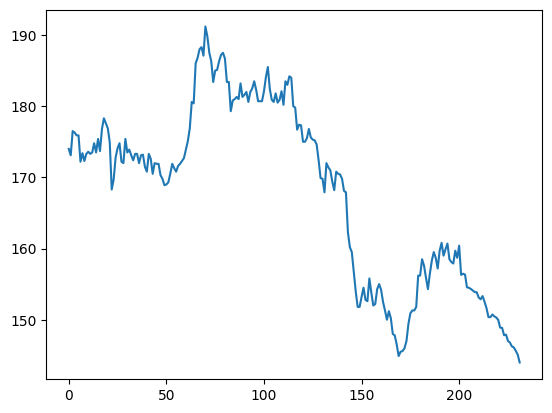

In [120]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[9000:])
